Links:

https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/posterior_predictive.html

https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/updating_priors.html

https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/

https://maxhalford.github.io/blog/bayesian-linear-regression/

In [1]:
import aesara
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


### Generating data

In [4]:
np.random.seed(16)

# Parameters
size = 1000
beta_0, beta_1 = 1, 2

# Simulate outcome variable
x = np.random.random(size)
y = beta_0 + beta_1 * x + np.random.randn(size)
data = pd.DataFrame(dict(x=x, y=y))
data.head()

,x,y
0,0.223291,-1.450413
1,0.523163,2.010962
2,0.550701,0.703249
3,0.045602,1.658509
4,0.360729,-0.055027


### Frequentist linear regression

In [5]:
X = sm.add_constant(data['x'])
Y = data['y']
reg = sm.OLS(Y, X)

model_freq = reg.fit()
beta_0_ols, beta_1_ols = model_freq.params

### Bayesian linear regression

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8935184275739534, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.


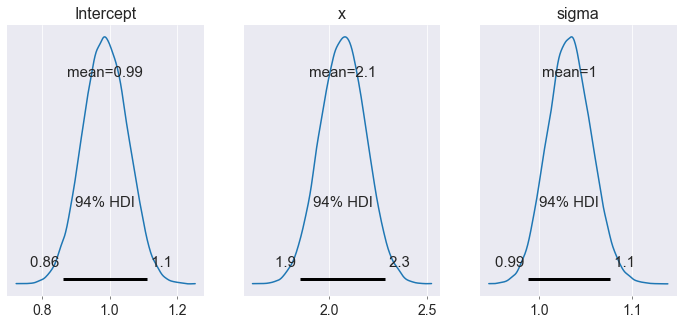

In [6]:
# Given your data, how your coefficients is going to be distributed
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('x', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    
    # Estimate of mean
    mu = intercept + slope * x
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    trace = pm.sample(10000, step)
pm.plot_posterior(trace, figsize = (12, 5));

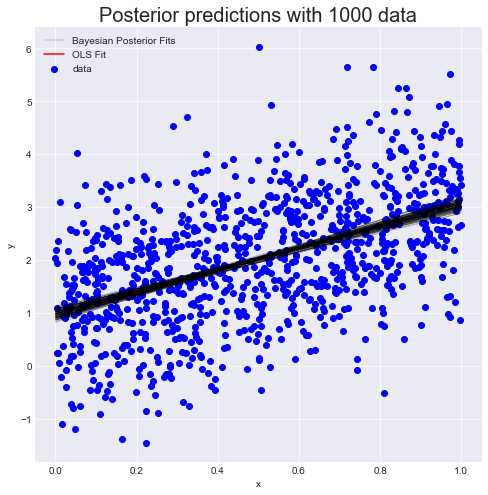

In [7]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(trace, samples=100, label='Bayesian Posterior Fits')
plt.scatter(x, y, c='blue', label='data')
x_line = np.arange(0, 1, 100)
plt.plot(x_line, x_line*beta_1_ols+beta_0_ols, label='OLS Fit', color='red')
plt.title('Posterior predictions with 1000 data', size = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, x, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


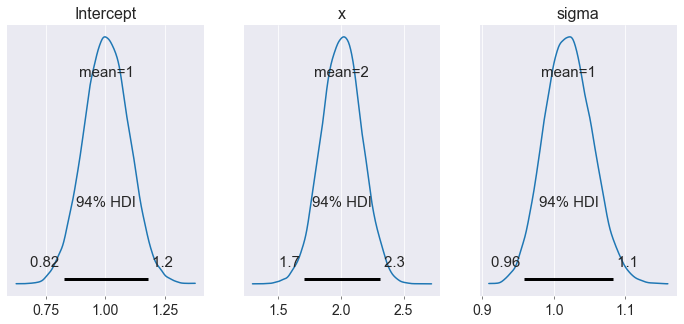

In [8]:
no_data = 500
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('x', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    
    # Estimate of mean
    np.random.seed(16)
    pos_random = np.random.choice(np.arange(len(x)), size=no_data)
    x_sample = x[pos_random]
    y_sample = y[pos_random]
    mu = intercept + slope * x_sample
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sample)
    
    # Sampler
    step = pm.NUTS()
    
    # Posterior distribution
    trace_500 = pm.sample(10000, step)
pm.plot_posterior(trace_500, figsize = (12, 5));

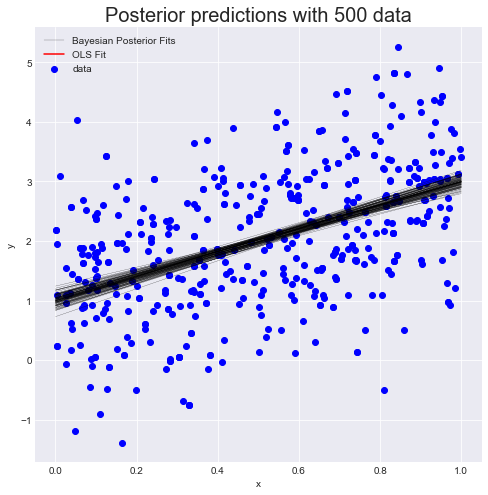

In [9]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(trace_500, samples=100, label='Bayesian Posterior Fits')
plt.scatter(x_sample, y_sample, c='blue', label='data')
x_line = np.arange(0, 1, 100)
plt.plot(x_line, x_line*beta_1_ols+beta_0_ols, label='OLS Fit', color='red')
plt.title('Posterior predictions with 500 data', size = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x7fa909df5280>>

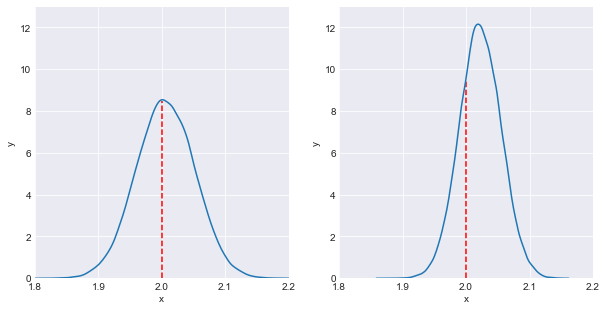

In [10]:
x_pred = 0.5
bayes_prediction_500 = trace_500['Intercept'] + trace_500['x'] * x_pred
bayes_prediction = trace['Intercept'] + trace['x'] * x_pred

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(bayes_prediction_500, label = 'Bayes Posterior Prediction', ax=axs[0])
axs[0].vlines(1+2*x_pred, ymin = 0, ymax = 8.5, label = 'OLS Prediction', colors = 'red', linestyles='--')
axs[0].set_xlim(1.8, 2.2)
axs[0].set_ylim(0, 13)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction', ax=axs[1])
axs[1].vlines(1+2*x_pred, ymin = 0, ymax = 9.5, label = 'OLS Prediction', colors = 'red', linestyles='--')
axs[1].set_xlim(1.8, 2.2)
axs[1].set_ylim(0, 13)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend

#### Updating priors Bayesian regression models

In [11]:
# Initialize random number generator
np.random.seed(16)

# True parameter values
beta0_true = 5
beta1_true = 7
beta2_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.5

# Simulate outcome variable
Y = beta0_true + beta1_true * X1 + beta2_true * X2 + np.random.randn(size)

In [12]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=12, sigma=1)
    beta2 = pm.Normal("beta2", mu=18, sigma=1)

    # Expected value of outcome
    mu = beta0 + beta1 * X1 + beta2 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [13]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.distributions.Interpolated(param, x, y)
    
traces = [trace]
for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = beta0_true + beta1_true * X1 + beta2_true * X2 + np.random.randn(size)

    model = pm.Model()
    with model:
        # Priors are posteriors from previous iteration
        beta0 = from_posterior("beta0", trace["beta0"])
        beta1 = from_posterior("beta1", trace["beta1"])
        beta2 = from_posterior("beta2", trace["beta2"])

        mu = beta0 + beta1 * X1 + beta2 * X2
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        trace = pm.sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9329700352502273, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.9042038374350441, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6875767128391534, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5636595631133352, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.9113850148080958, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9333337437994421, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


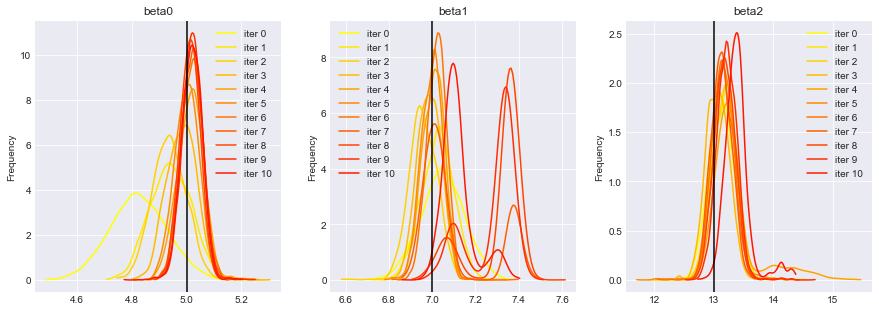

In [14]:
cmap = matplotlib.cm.autumn
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, param in enumerate(["beta0", "beta1", "beta2"]):
    for no, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        axs[i].plot(x, y, color=cmap(1 - no / len(traces)), label=f'iter {no}')
    axs[i].axvline({"beta0": beta0_true, "beta1": beta1_true, "beta2": beta2_true}[param], c="k")
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(param)
    axs[i].legend()